In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pathlib import Path

In [16]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [17]:
# Load the data
data_dir = Path("~/Data").expanduser() / "bci-i-idun-eeg-analysis-challenge"
X = np.load(data_dir / "S001_X.npy")
Y = np.load(data_dir / "S001_Y.npy")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape[0], X_train.shape[1], -1)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape[0], X_test.shape[1], -1)

# Convert Y from text labels to integer labels
_markers = list(set(Y))
y_train = [_markers.index(m) for m in y_train]
y_test = [_markers.index(m) for m in y_test]

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)


In [18]:
# Define the LSTM model
class EEG_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(EEG_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[2]
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(Y))
model = EEG_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [19]:
# Define data augmentation
class TimeSeriesAugmentation:
    def __init__(self, noise_level=0.05, shift_range=10):
        self.noise_level = noise_level
        self.shift_range = shift_range
    
    def add_noise(self, x):
        noise = torch.randn_like(x) * self.noise_level
        return x + noise
    
    def time_shift(self, x):
        shift = torch.randint(-self.shift_range, self.shift_range, (1,)).item()
        return torch.roll(x, shifts=shift, dims=0)
    
    def scale(self, x):
        scale_factor = torch.rand(1) * 0.4 + 0.8
        return x * scale_factor

class AugmentedDataset(Dataset):
    def __init__(self, X, y, augment=True):
        self.X = X
        self.y = y
        self.augment = augment
        self.aug = TimeSeriesAugmentation()
    
    def __getitem__(self, idx):
        x = self.X[idx].clone()
        if self.augment:
            if torch.rand(1) < 0.5:
                x = self.aug.add_noise(x)
            if torch.rand(1) < 0.5:
                x = self.aug.time_shift(x)
            if torch.rand(1) < 0.5:
                x = self.aug.scale(x)
        return x, self.y[idx]
    
    def __len__(self):
        return len(self.X)

# Create data loaders
train_dataset = AugmentedDataset(X_train_tensor, y_train_tensor)
val_dataset = AugmentedDataset(X_test_tensor, y_test_tensor, augment=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [20]:
# import time

# # Training loop
# num_epochs = 20
# patience = 4
# best_val_loss = float("inf")  # init with a large value
# epochs_no_improve = 0
# train_losses, val_losses, accuracies = [], [], []

# start_time = time.time()

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     for X_batch, y_batch in train_loader:
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#         optimizer.zero_grad()
#         output = model(X_batch)
#         loss = criterion(output, y_batch)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     # Compute the average training loss
#     train_loss /= len(train_loader)
#     train_losses.append(train_loss)

#     # Evaluation
#     model.eval()
#     y_pred = []
#     y_true = []
#     val_loss = 0.0
#     with torch.no_grad():
#         for X_batch, y_batch in val_loader:
#             X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#             output = model(X_batch)
#             _, predicted = torch.max(output, 1)
#             y_pred.extend(predicted.cpu().numpy())
#             y_true.extend(y_batch.cpu().numpy())
#             loss = criterion(output, y_batch)
#             val_loss += loss.item()

#         # Compute the average validation loss
#         val_loss /= len(val_loader)
#         val_losses.append(val_loss)

#         # Compute the accuracy
#         accuracy = accuracy_score(y_true, y_pred)
#         accuracies.append(accuracy)
    
#     # Early stopping
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         epochs_no_improve = 0
#         torch.save(model.state_dict(), "best_model.pth")
#     else:
#         epochs_no_improve += 1
#         if epochs_no_improve == patience:
#             print(f"Early stopping after {epoch+1} epochs.")
#             break


#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}")

# # Load the best model
# model.load_state_dict(torch.load("best_model.pth"))

# end_time = time.time()
# print(f"Training took {end_time - start_time:.2f} seconds.")



In [21]:
import time

# Training loop
num_epochs = 20
patience = 4
best_val_loss = float("inf")  # init with a large value
epochs_no_improve = 0
train_losses, val_losses, accuracies = [], [], []

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Compute the average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Evaluation
    model.eval()
    y_pred = []
    y_true = []
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            _, predicted = torch.max(output, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())
            loss = criterion(output, y_batch)
            val_loss += loss.item()

        # Compute the average validation loss
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Compute the accuracy
        accuracy = accuracy_score(y_true, y_pred)
        accuracies.append(accuracy)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping after {epoch+1} epochs.")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

end_time = time.time()
print(f"Training took {end_time - start_time:.2f} seconds.")

Epoch 1/20, Train Loss: 1.7462, Val Loss: 1.6599, Accuracy: 0.3206
Epoch 2/20, Train Loss: 1.4931, Val Loss: 1.6213, Accuracy: 0.3206
Epoch 3/20, Train Loss: 1.4993, Val Loss: 1.5717, Accuracy: 0.3053
Epoch 4/20, Train Loss: 1.4826, Val Loss: 1.5691, Accuracy: 0.3206
Epoch 5/20, Train Loss: 1.4745, Val Loss: 1.5724, Accuracy: 0.3206
Epoch 6/20, Train Loss: 1.4751, Val Loss: 1.5693, Accuracy: 0.3206
Epoch 7/20, Train Loss: 1.4721, Val Loss: 1.5770, Accuracy: 0.3206
Early stopping after 8 epochs.
Training took 5193.03 seconds.


In [22]:
# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.3206


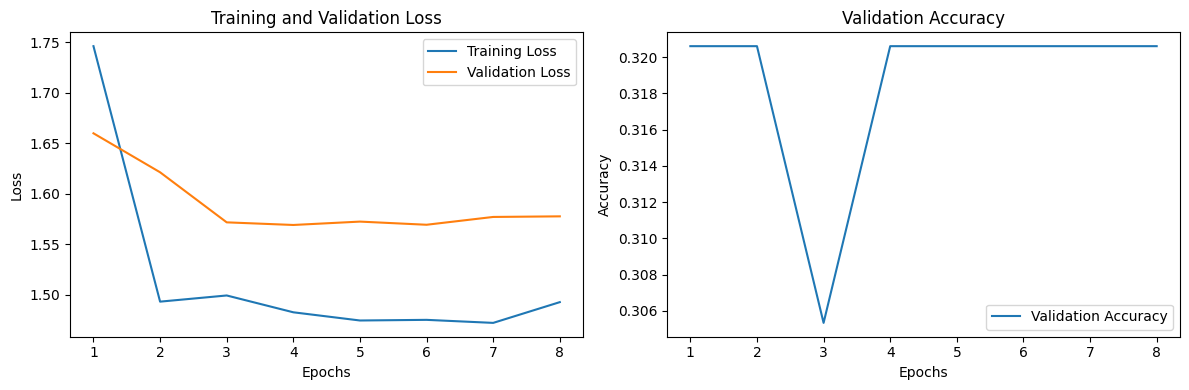

In [23]:
import matplotlib.pyplot as plt

# Plotting the training and validation losses and accuracy
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the data
data_dir = Path("~/Data").expanduser() / "bci-i-idun-eeg-analysis-challenge"
X = np.load(data_dir / "S001_X.npy")
Y = np.load(data_dir / "S001_Y.npy")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape[0], X_train.shape[1], -1)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape[0], X_test.shape[1], -1)

# Convert Y from text labels to integer labels
_markers = list(set(Y))
y_train = [_markers.index(m) for m in y_train]
y_test = [_markers.index(m) for m in y_test]

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Define the LSTM model
class EEG_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(EEG_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[2]
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(Y))
model = EEG_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define data augmentation
class TimeSeriesAugmentation:
    def __init__(self, noise_level=0.05, shift_range=10):
        self.noise_level = noise_level
        self.shift_range = shift_range
    
    def add_noise(self, x):
        noise = torch.randn_like(x) * self.noise_level
        return x + noise
    
    def time_shift(self, x):
        shift = torch.randint(-self.shift_range, self.shift_range, (1,)).item()
        return torch.roll(x, shifts=shift, dims=0)
    
    def scale(self, x):
        scale_factor = torch.rand(1) * 0.4 + 0.8
        return x * scale_factor

class AugmentedDataset(Dataset):
    def __init__(self, X, y, augment=True):
        self.X = X
        self.y = y
        self.augment = augment
        self.aug = TimeSeriesAugmentation()
    
    def __getitem__(self, idx):
        x = self.X[idx].clone()
        if self.augment:
            if torch.rand(1) < 0.5:
                x = self.aug.add_noise(x)
            if torch.rand(1) < 0.5:
                x = self.aug.time_shift(x)
            if torch.rand(1) < 0.5:
                x = self.aug.scale(x)
        return x, self.y[idx]
    
    def __len__(self):
        return len(self.X)

# Create data loaders
train_dataset = AugmentedDataset(X_train_tensor, y_train_tensor)
val_dataset = AugmentedDataset(X_test_tensor, y_test_tensor, augment=False)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training function
def train_model(model, train_loader, val_loader, num_epochs, lr, patience, device='cuda'):
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # weight_decay is L2 regularization
        
    model = model.to(device)
    best_val_loss = np.inf
    best_model = None
    epochs_no_improve = 0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_acc = 100. * correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        y_pred = []
        y_true = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                y_pred.extend(predicted.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

        val_acc = 100. * correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model = model.state_dict()
            torch.save(best_model, "best_model.pth")
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"Early stopping after {epoch+1} epochs.")
                break
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%')
        print('--------------------')
    
    end_time = time.time()
    print(f"Training took {end_time - start_time:.2f} seconds.")
    
    return best_model, train_losses, val_losses, train_accuracies, val_accuracies

# Set the number of epochs
num_epochs = 30
patience = 3
learnging_rate = 1e-3

# Train model
best_model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(model=model, train_loader=train_loader, val_loader=val_loader, num_epochs=num_epochs, device=device, lr=learnging_rate, patience=patience)

# Load the best model
model.load_state_dict(torch.load("best_model.pth"))

# Compute metrics
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

balanced_acc = balanced_accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt=".2f", cmap="Blues", xticklabels=_markers, yticklabels=_markers)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f"LSTM - Balanced Accuracy: {balanced_acc:.4f}, F1: {f1:.4f}")
plt.show()

# Plotting the training and validation losses and accuracy
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch [1/30]
Train Loss: 1.9159, Train Acc: 30.34%
Val Loss: 1.9037, Val Acc: 30.53%
--------------------


KeyboardInterrupt: 